
# <center><font color= #F08080 > <b>CU55_Modelo agregado de estimación del gasto medio por turista</font></center>

#  <font color='green'>IV. Model development</font>

En este anexo se incluye el código utilizado durante el desarrollo 
de los modelos incluidos en el caso de uso.

## Modelo XGBOOST



In [1]:
Sys.setlocale(category = "LC_ALL", locale = "es_ES.UTF-8")

[1] "es_ES.UTF-8/es_ES.UTF-8/es_ES.UTF-8/C/es_ES.UTF-8/C"

### Paquetes

In [2]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(xgboost)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




### Datos

In [3]:
gasto_municipio <- read_csv("CU_55_05_02_gasto_municipio.csv")

dm <- gasto_municipio |> 
  mutate(nmes = factor(str_sub(mes, 6, 7)),
         pais_orig = factor(pais_orig)) |> 
  select(nmes, pais_orig, turistas, gasto) |> 
  filter(str_detect(pais_orig, "Total", negate = TRUE))

mm <- model.matrix( ~ ., dm)

Rows: 50294 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): mes, pais_orig_cod, pais_orig, mun_dest, CMUN
dbl (3): mun_dest_cod, turistas, gasto

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Splitting

In [4]:
# mm <- Matrix::sparse.model.matrix(~., data = dm)

train <- sample(1:nrow(mm), round(0.8* nrow(mm)), replace = FALSE)
x.train <- mm[train, 1:(ncol(mm) - 1)]
y.train <- mm[train, ncol(mm)]

x.test <- mm[-train, 1:(ncol(mm) - 1)]
y.test <- mm[-train, ncol(mm)]

## Modelo

[1]	train-rmse:83.689009 
[2]	train-rmse:60.628673 
[3]	train-rmse:45.010463 
[4]	train-rmse:34.669155 
[5]	train-rmse:27.991529 
[6]	train-rmse:23.817382 
[7]	train-rmse:21.389982 
[8]	train-rmse:19.915366 
[9]	train-rmse:18.972105 
[10]	train-rmse:18.453314 


Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
pais_origChina,0.53268228,0.14526697,0.02821317
pais_origSuiza,0.15703532,0.09873650,0.01880878
pais_origColombia,0.05277161,0.07341269,0.01567398
pais_origEE.UU.,0.04806993,0.07826957,0.01567398
pais_origFrancia,0.03114864,0.05373272,0.02821317
nmes06,0.02257595,0.05999225,0.06269592


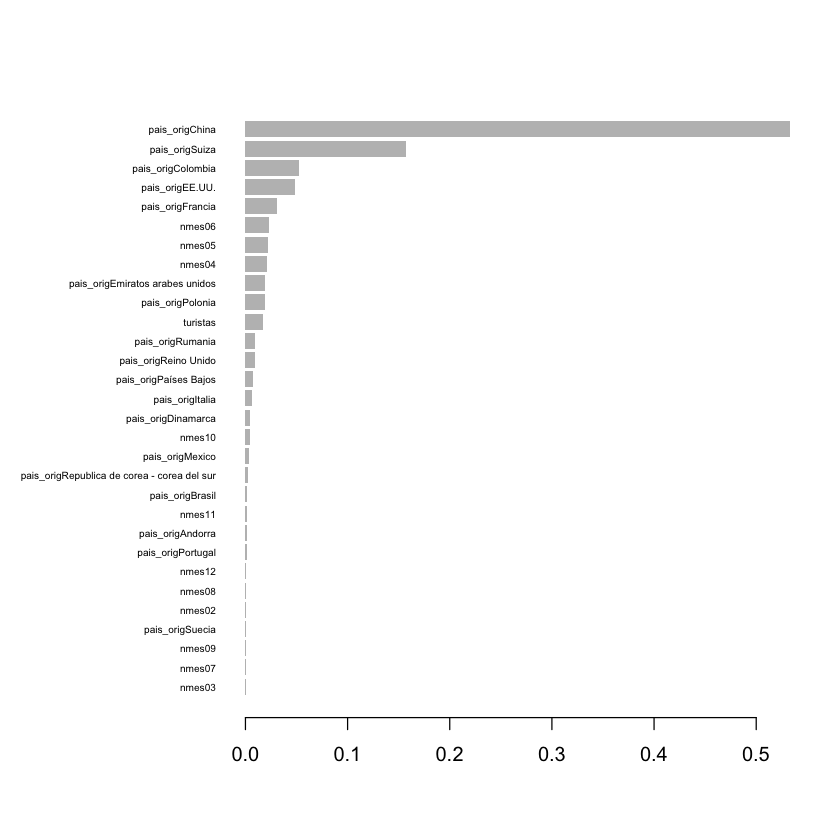

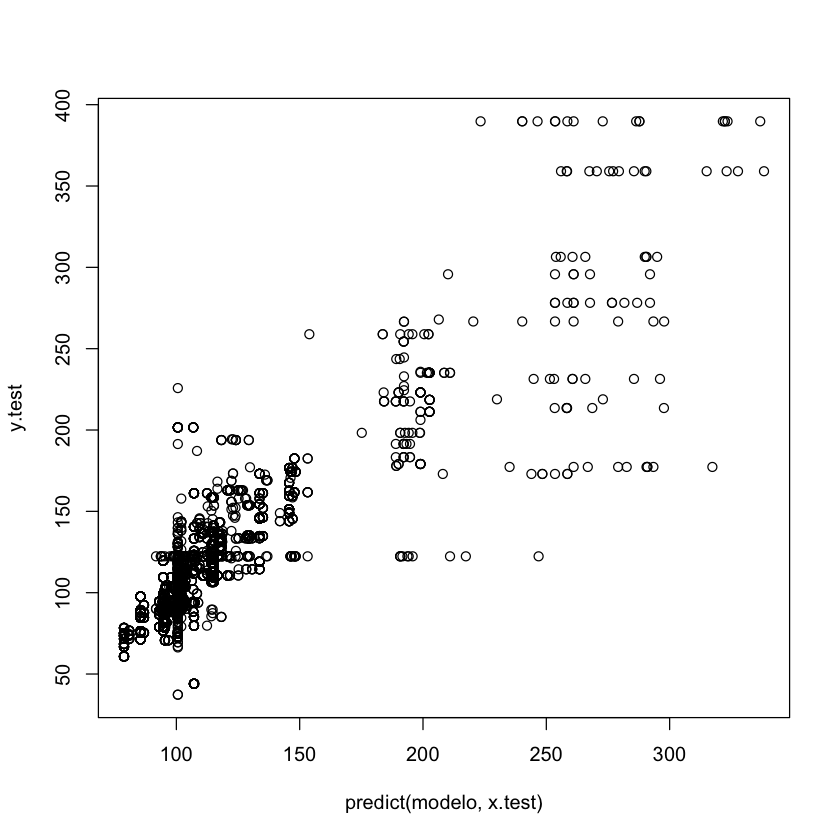

In [5]:
modelo <- xgboost(data = x.train, label = y.train, nrounds = 10)

importance <- xgb.importance(feature_names = colnames(x.train), model = modelo)
head(importance)

xgb.plot.importance(importance_matrix = importance)

plot(predict(modelo, x.test), y.test)

write_rds(modelo, "modelo_xgb.rds")

## Predicción

In [6]:
### predicción
## 1. tipo escenario origen

escenario <- read_csv("ESCENARIO_ORIGEN.csv") 

escenario.x <- escenario |> 
  mutate(nmes = factor(str_sub(mes, 6, 7), levels = levels(dm$nmes)),
         pais_orig = factor(pais_orig, levels = levels(dm$pais_orig))) |> 
  select(nmes, pais_orig, turistas) |> 
  model.matrix(~., data = _)

predict(modelo, escenario.x)
## 1. tipo escenario destino

escenario <- read_csv("ESCENARIO_DESTINO.csv") 

escenario.x <- escenario |> 
  mutate(nmes = factor(str_sub(mes, 6, 7), levels = levels(dm$nmes)),
         pais_orig = factor(pais_orig, levels = levels(dm$pais_orig))) |> 
  select(nmes, pais_orig, turistas) |> 
  model.matrix(~., data = _)

predict(modelo, escenario.x)

Rows: 30 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): mes, pais_orig, mun_dest
dbl (1): turistas

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 85.46945 85.46945 85.46945 85.46945 85.46945 85.46945 85.46945 85.46945
 [9] 85.46945 85.46945 85.46945 85.46945 85.46945 85.46945 85.46945 85.46945
[17] 85.46945 85.46945 85.46945 85.46945 85.46945 86.86553 86.86553 86.86553
[25] 86.86553 86.86553 86.86553 86.86553 86.86553 86.86553

Rows: 24 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): mes, pais_orig, mun_dest
dbl (1): turistas

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 100.59856 100.59856 100.59856  95.37618  85.46945 100.59856 100.59856
 [8]  94.65097 100.59856  93.05251  78.77147 102.96220 112.43428 100.59856
[15] 115.14487 100.59856 194.72865 100.59856 100.59856 100.59856 100.59856
[22] 133.71532 145.71632 258.42023